# Outliers detection
### Mikołaj Malec

In [1]:
import pandas as pd
import numpy as np


#DBSCAN
from sklearn.cluster import DBSCAN
#HDBSCAN
from hdbscan import HDBSCAN
#One-class SVM
from sklearn.svm import OneClassSVM
#Isolation Forests
from sklearn.ensemble import IsolationForest
#Local Outlier Factor in order to detect possible outliers / anomalies.
from sklearn.neighbors import LocalOutlierFactor

#metrics
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, precision_score, f1_score

from seaborn import pairplot


### The effect of various methods designed to detect outliers/anomalies.

#### Short description of the problem

Detecting outliers or anomalies involves identifying observations or data points that deviate significantly from the norm or expected pattern in a dataset. Outliers can be either data points, that is too far from the average or values that are too rare or too frequent. Detecting outliers can help to identify potential errors or problems in the data collection process, or it can reveal interesting or important information about the dataset that may not be apparent from the average or summary statistics.

The original thyroid disease (ann-thyroid) dataset from the UCI machine learning repository is a classification dataset, which is suited for training ANNs. It has 7200 instances. It has 15 categorical and 6 real attributes. The problem is determining whether a patient referred to the clinic is hypothyroid. 

#### Short description of the problem

I will focus on the decision of outliers based on the paper [Liu, Fei Tony, Ting, Kai Ming and Zhou, Zhi-Hua. Isolation forest. Data Mining, 2008. ICDM’08.]. I will treat those classes as ground truth and evaluate the results of outliers detection algorithms.

As suggested in the paper, I will remove all binary variables in order to compare chosen anomaly detection algorithms.

Because some detection algorithms use euclidean distance, I will standardize the dataset by MinMax.

In [2]:
data = pd.read_csv("annthyroid.data.csv")

#In [Liu, Fei Tony, Ting, Kai Ming and Zhou, Zhi-Hua. Isolation forest. Data Mining, 2008. ICDM’08.] 
#it was suggested to remove all binary variables in order to compare chosen anomaly detection algorithms.
#Drop Vi where i is from {2,3,...,16}
columns_to_drop = np.core.defchararray.add( "V", np.arange(2,17).astype(str) )
data = data.drop(columns_to_drop, axis=1)

#standarize dataset
y = data["V22"]
data = data.drop("V22", axis=1)
data = (data - data.min()) / (data.max() - data.min())
data["V22"] = y

In [3]:
#data info
print(data.info())
print(data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7200 entries, 0 to 7199
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   V1      7200 non-null   float64
 1   V17     7200 non-null   float64
 2   V18     7200 non-null   float64
 3   V19     7200 non-null   float64
 4   V20     7200 non-null   float64
 5   V21     7200 non-null   float64
 6   V22     7200 non-null   int64  
dtypes: float64(6), int64(1)
memory usage: 393.9 KB
None
                V1          V17          V18          V19          V20  \
count  7200.000000  7200.000000  7200.000000  7200.000000  7200.000000   
mean      0.531790     0.009172     0.108506     0.179649     0.374250   
std       0.197156     0.043357     0.042001     0.060148     0.088354   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.375000     0.001340     0.091922     0.145485     0.324074   
50%       0.562500     0.003208     0.109192     0.175585   

In [4]:
#data V22 bucket %
data["V22"].value_counts() / len(data)

3    0.925833
2    0.051111
1    0.023056
Name: V22, dtype: float64

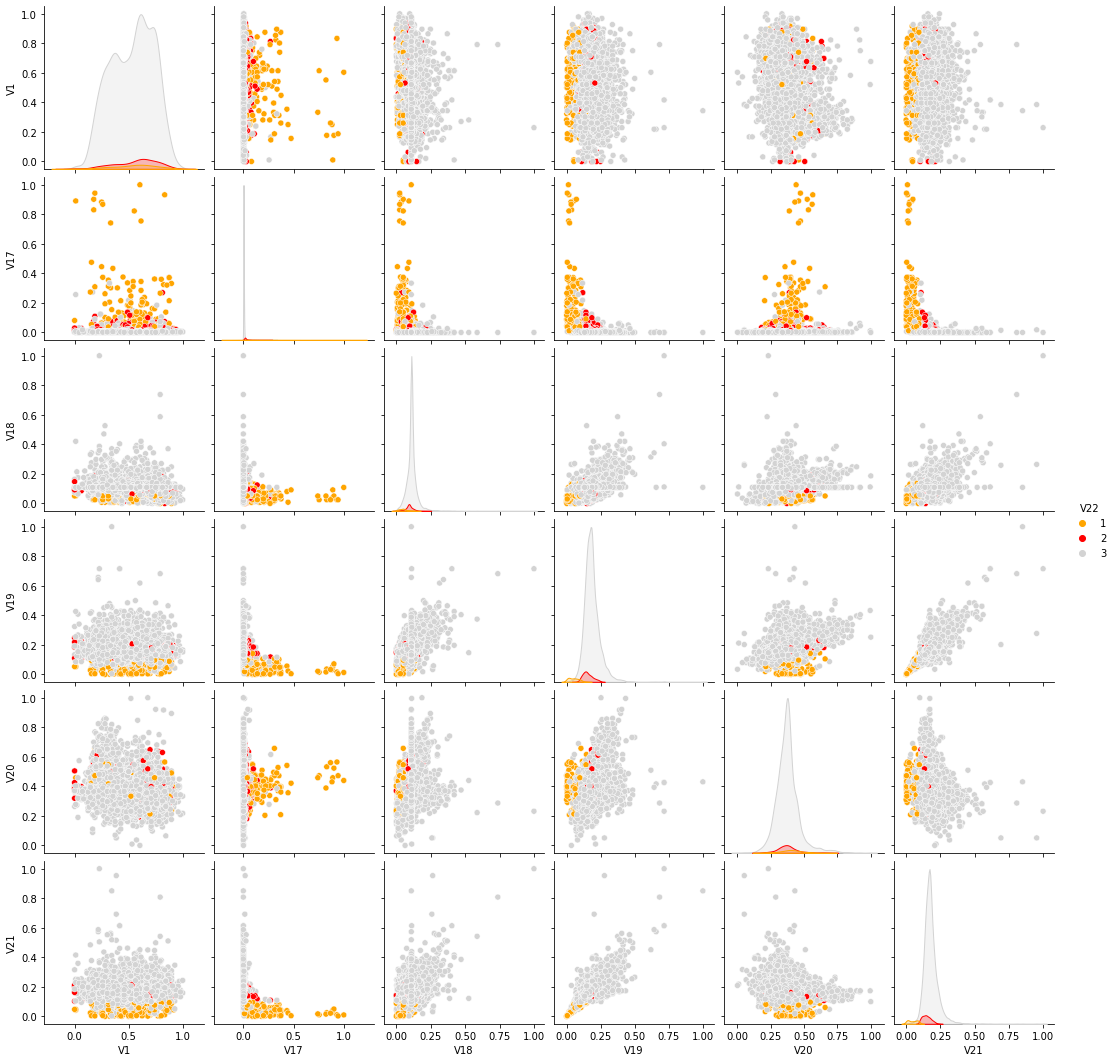

In [5]:
#data visualization
pairplot( data, hue="V22", palette={3:"lightgray",2:"red",1:"orange"})

For me, the "true" outliers are based on V17 variable or because they are too close to 0 in others. I would consider some data points elsewhere as outliers, but it may be because of the dropping to two-dimensional space.

In [6]:
def score( y, y_p):
    s0 = np.sum(y_p) #number of outliers
    s1 = accuracy_score( y, y_p)
    s2 = roc_auc_score( y, y_p)
    s3 = precision_score( y, y_p, zero_division=0)
    s4 = recall_score( y, y_p)
    s5 = f1_score( y, y_p)
    return  np.array( ( s0, s1, s2, s3, s4, s5) )

def append_score( scores_pd, out, model_name):
    score_k = {'Algorytm': model_name,
               '# outliers': [out[0]],
               'Accuracy': [out[1]],
               'Roc_auc': [out[2]],
               'Precision': [out[3]],
               'Recall': [out[4]],
               'F1': [out[5]]
              }
    score_k_df = pd.DataFrame(score_k)
    score_k_df = score_k_df.set_index('Algorytm')

    scores_pd = pd.concat( [scores_pd, score_k_df])
    return scores_pd

#### I will use the following metrics:

\# outliers - number of predicted outliers to compare 'greed' of algorithms

accuracy - the results should not be meaningful, as the data are very unbalanced

Roc_auc - Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores

Precision - the ability of the classifier not to label as positive a sample that is negative

Recall - recall is the ability of the classifier to find all the positive samples

F1 - harmonic mean of the precision and recall, better to use than accuracy

In [7]:
X = data.drop("V22", axis=1) #only data
true_outliers = data["V22"] < 3 #y in {1,2}

dtypes = np.dtype(
    [
        ("# outliers", int),
        ("Accuracy", float),
        ("Roc_auc", float),
        ("Precision", float),
        ('Recall',float),
        ('F1',float)
    ]
)
scores_pd = pd.DataFrame(np.empty(0, dtype=dtypes))


#### I will use two comparason simple models, to have a base to compere metrics of tested algorythms

Perfect model - all labels where choosen corectly (i.e. 100% accurcay)

Dummy model - model labeling all data points as not outlioers

In [8]:
#perfect model
#all corect categorised
out = score( true_outliers, true_outliers)
scores_pd = append_score( scores_pd, out, 'Perfect model')
#dummy model
#no outliers
out = score( true_outliers, np.zeros(len(true_outliers)))
scores_pd = append_score( scores_pd, out, 'Dummy model')

### DBSCAN

The DBSCAN algorithm views clusters as areas of high density separated by areas of low density. The central component of the DBSCAN is the concept of core samples, which are samples that are in areas of high density. A cluster is therefore a set of core samples, each close to the other (measured by some distance measure) and a set of non-core samples that are close to a core sample (but are not themselves core samples). There are two parameters to the algorithm, min_samples, and eps, which define formally what we mean when we say dense. I will test the impact of eps on the DBSCAN algorithm.

eps - The maximum distance between two samples for one to be considered as in the neighborhood of the other. This is not a maximum bound on the distances of points within a cluster. This is the most important DBSCAN parameter to choose appropriately for your data set and distance function. Default is 0.5.

In [9]:
#test DBSCAN
eps_list = [0.01, 0.03, 0.05, 0.1, 0.3, 0.5]

for eps in eps_list:
    
    clustering_DBSCAN = DBSCAN(eps=eps).fit(X)
    #-1 are outliers
    outliers_DBSCAN = clustering_DBSCAN.labels_ == -1
    out = score( true_outliers, outliers_DBSCAN)

    scores_pd = append_score( scores_pd, out, model_name='DBSCAN: '+str(eps))

### HDBSCAN

HDBSCAN is a clustering algorithm developed by Campello, Moulavi, and Sander. It extends DBSCAN by converting it into a hierarchical clustering algorithm and then using a technique to extract a flat clustering based in the stability of clusters.

The immediate advantage of this algorithm is that we can have varying density clusters; the second benefit is that we have eliminated the epsilon parameter as we no longer need it to choose a cut of the dendrogram. Instead, we have a new parameter min_cluster_size which is used to determine whether points are ‘falling out of a cluster’ or splitting to form two new clusters. This trades an unintuitive parameter for one that is not so hard to choose for EDA (what is the minimum size cluster I am willing to care about?). I will test impact of this parameter. The default is 5.

In [10]:
#test HDBSCAN
min_cluster_size_list = [3, 5, 10, 30, 50]

for min_cluster_size in min_cluster_size_list:
    
    clustering_HDBSCAN = HDBSCAN( min_cluster_size=min_cluster_size).fit(X)
    #-1 are outliers
    outliers_HDBSCAN = clustering_HDBSCAN.labels_ == -1
    out = score( true_outliers, outliers_HDBSCAN)

    scores_pd = append_score( scores_pd, out, model_name='HDBSCAN: '+str(min_cluster_size))

### One Class SVM

One-Class Support Vector Machine (SVM) is an unsupervised model for anomaly or outlier detection. Unlike the regular supervised SVM, the one-class SVM does not have target labels for the model training process. Instead, it learns the boundary for the normal data points and identifies the data outside the border to be anomalies.

In [11]:
#test OneClassSVM
clustering_OneClassSVM = OneClassSVM( ).fit(X)
#-1 are outliers
outliers_OneClassSVM = clustering_OneClassSVM.fit_predict(X) == -1
out = score( true_outliers, outliers_OneClassSVM)

scores_pd = append_score( scores_pd, out, model_name='OneClassSVM')

### Isolation Forest

One efficient way of performing outlier detection in high-dimensional datasets is to use random forests. The anomaly score is the number of splittings required to isolate a sample that is equivalent to the path length from the root node to the terminating node.

As the Isolation Forest is not deterministic, I will repeat each test 10 times.

n_estimators is a number of base estimators in the ensemble. I will test the impact of this parameter on the algorithm.

In [12]:
#test IsolationForest
n_estimators_list = [30, 50, 100, 300, 500]

K = 10
out = np.empty((K,6))

for n_estimators in n_estimators_list:
    for k in range(K):
        clustering_IsolationForest = IsolationForest( n_estimators=n_estimators).fit(X)
        #-1 are outliers
        outliers_IsolationForest = clustering_IsolationForest.fit_predict(X) == -1
        out[k] = score( true_outliers, outliers_IsolationForest)

    out_df = pd.DataFrame(out)
    out_mean = out_df.mean()
    scores_pd = append_score( scores_pd, out_mean, model_name='IsolationForest: '+str(n_estimators))

### Local Outlier Factor

It measures the local density deviation of a given data point with respect to its neighbors. In practice, the local density is obtained from the k-nearest neighbors. The LOF score of observation is equal to the ratio of the average local density of its k-nearest neighbors, and its own local density: a normal instance is expected to have a local density similar to that of its neighbors, while abnormal data are expected to have much smaller local density.

The number k of neighbors considered, (alias parameter n_neighbors) is typically chosen 1) greater than the minimum number of objects a cluster has to contain, so that other objects can be local outliers relative to this cluster, and 2) smaller than the maximum number of close by objects that can potentially be local outliers. In practice, such information is generally not available, and taking n_neighbors=20 appears to work well in general. I will test the impact of this parameter on the algorithm.

In [13]:
#test LocalOutlierFactor
n_neighbors_list = [5, 10, 20, 50, 100]


for n_neighbors in n_neighbors_list:
    
    out = np.empty(6)

    clustering_LocalOutlierFactor = LocalOutlierFactor( n_neighbors=n_neighbors).fit(X)
    #-1 are outliers
    outliers_LocalOutlierFactor = clustering_LocalOutlierFactor.fit_predict(X) == -1
    out = score( true_outliers, outliers_LocalOutlierFactor)

    scores_pd = append_score( scores_pd, out, model_name='LocalOutlierFactor: '+str(n_neighbors))

In [14]:
scores_pd.loc[:,"# outliers"] = scores_pd["# outliers"].astype(int)
scores_pd.style.background_gradient() 

,# outliers,Accuracy,Roc_auc,Precision,Recall,F1
Perfect model,534,1.000000,1.000000,1.000000,1.000000,1.000000
Dummy model,0,0.925833,0.500000,0.000000,0.000000,0.000000
DBSCAN: 0.01,7075,0.091528,0.509376,0.075477,1.000000,0.140360
DBSCAN: 0.03,2252,0.703333,0.659768,0.144316,0.608614,0.233309
DBSCAN: 0.05,734,0.873611,0.625974,0.243869,0.335206,0.282334
DBSCAN: 0.1,122,0.920556,0.533325,0.344262,0.078652,0.128049
DBSCAN: 0.3,6,0.925000,0.499550,0.000000,0.000000,0.000000
DBSCAN: 0.5,1,0.925694,0.499925,0.000000,0.000000,0.000000
HDBSCAN: 3,5335,0.312361,0.564039,0.086036,0.859551,0.156415
HDBSCAN: 5,6371,0.181250,0.532852,0.079265,0.945693,0.146271


## Conclusions

### Metrics conclusions

Accuracy is not the best metric to compare the efficiency of the algorithms, as the dummy algorithm achieved the best accuracy of all (except the perfect algorithm). 

The recall is also not the best metric in this case, as taking a lot of data points will bring better results on this metric. For example, DBSCAN with esp=0.01 achieved a recall of 1, but labeled 0.97 of the dataset as outliers.

Precision is better than previous ones, as it ensures, that important data points are not labeled as outliers. Alorytghms with high Precision also had a big F1 score.

Roc_auc can be understood as 'understanding' of the algorithm and all 'good' algorithms have high Roc_auc score, but it has to be used with caution, as the best Roc_auc score was scored by DBSCAN with esp=0.03 (exempt perfect algorithm), but it had very low precision score.

### Best algorithm conclusions

Based on chosen metrics I chose Isolation Forest as the best algorithm in this case. Second is Local Outlier Factor with n_neighbors=100 and third is DBSCAN with eps=0.05.

There is no good explanation, as to why algorithms some algorithms were better than others, but good-performing algorithms often had a number of predicted outliers close to the true number of them.

### DBSCAN impact of 'esp'

The bigger 'esp' gets the smaller number of predicted outliers chosen.

Tooning of 'esp' is necessary for the good performance of the algorithm.

### HDBSCAN impact of 'min_cluster_size'

HDBSCAN always labeled more points than necessary as outliers.

The bigger 'min_cluster_size' gets, the bigger number of predicted outliers is chosen.

### Isolation Forest impact of 'n_estimators'

The number of base estimators in the ensemble doesn't have a big impact on the algorithm performance (maybe for smaller values it would have).

### Local Outlier Factor impact of 'n_neighbors'

The bigger 'n_neighbors' gets, the bigger number of predicted outliers chosen.

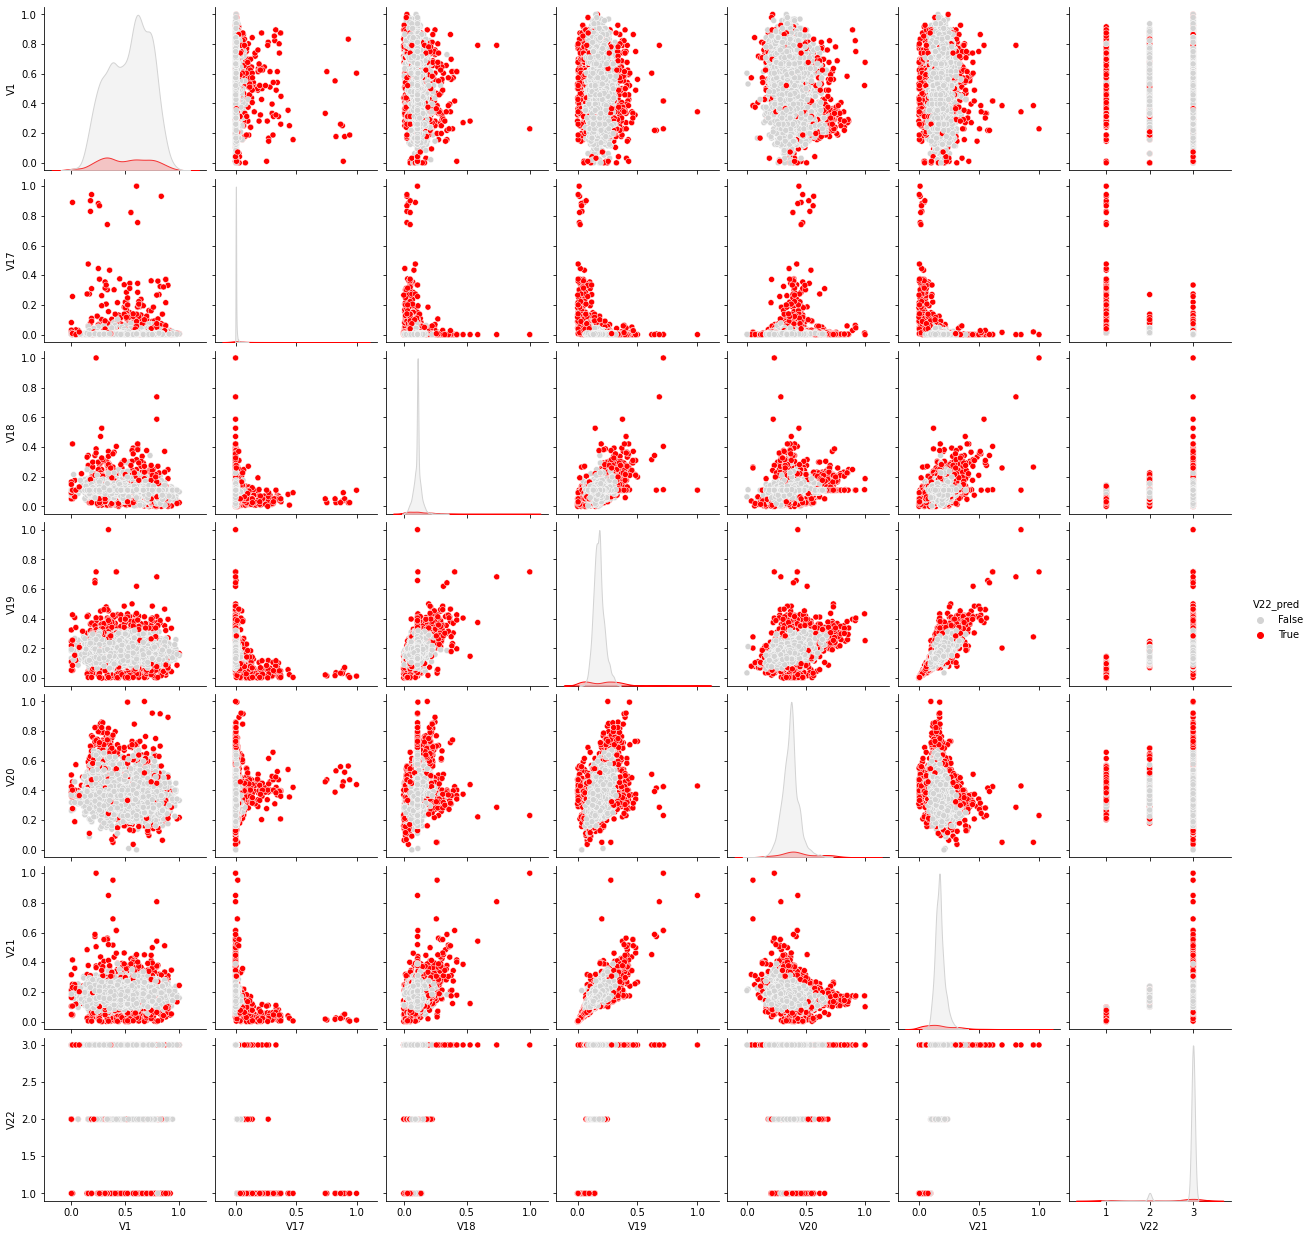

In [18]:
#visualisation for one of the best algortythm
#Isolation Forest with n_estimators=30

clustering_IsolationForest = IsolationForest( n_estimators=30).fit(X)
#-1 are outliers
outliers_IsolationForest = clustering_IsolationForest.fit_predict(X) == -1

data_copy = data.copy()
data_copy["V22_pred"] = outliers_IsolationForest

g = pairplot( data_copy, hue="V22_pred", palette={0:"lightgray",1:"red"})